In [1]:
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
sys.path.append(parent_dir)
import torch
import system.units as units
import system.topology as topology
import system.box as box
import forces.twobody as twobody
import system.system as sys
from integrators.NVE import NVE
from integrators.NVT import NVT
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import itertools
from tqdm import trange
from utils import *
import freud
%matplotlib inline
from IPython.display import clear_output, display
device = "cuda"


╔═══════════════════════════════════════════════════╗
║                                                   ║
║  ██████╗   ██████╗    ██╗      ██████╗   ██╗  ██╗ ║
║ ██╔════╝  ██╔══██╗   ██╔██╗    ██╔══██╗  ██║ ██╔╝ ║
║ ╚█████╗   ██████╔╝  ██╔╝╚██╗   ██████╔╝  █████╔╝  ║
║  ╚═══██╗  ██╔═══╝  ██╔╝  ╚██╗  ██╔══██╗  ██╔═██╗  ║
║ ██████╔╝  ██║     ██╔╝    ╚██╗ ██║  ██║  ██║ ╚██╗ ║
║ ╚═════╝   ╚═╝     ╚═╝      ╚═╝ ╚═╝  ╚═╝  ╚═╝  ╚═╝ ║
║                                                   ║
║     Statistical Physics Autodiff Research Kit     ║
╚═══════════════════════════════════════════════════╝

          V(r)           ψ, φ              q
           │               │               │
           ○               ○               ○
         ╱ | ╲           ╱ | ╲           ╱ | ╲
        ○  ○  ○         ○  ○  ○         ○  ○  ○
         ╲ | ╱           ╲ | ╱           ╲ | ╱
           ○               ○               ○
           │               │               │
          g(r)             F         

In [2]:
arity_table = (
    ["mie","ewald"], 
    [2,2]
)
top = topology.Topology(arity_table)
print(top)
NL = 10
for i in range(NL**3):
    for j in range(i):
        top.add(2,"mie",(i,j))
        top.add(2,"ewald",(i,j))

b = box.Box([10.59839833,10.59839833,10.59839833],["p","p","p"])
print(b)

u = units.UnitSystem()
print(u)

B = 32
pos = make_sc_lattice(a=1.05, nx=NL, ny=NL, nz=NL, batch=B)  
N = len(pos[0])

pos = pos - pos.mean(dim=1, keepdim=True) + torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2
mom = 0.59*torch.randn(B,N,3,device=device)
mass = torch.ones(N,device=device)

charge = torch.ones(N,device=device)
charge[:int(N/4)] *= 2
charge[int(N/2):] *= -1
charge[-int(N/4):] *= 2
idx = torch.randperm(charge.shape[0])
charge = charge[idx].view(charge.size())
A_idx = torch.where(charge == -1)[0]
B_idx = torch.where(charge == 1)[0]
C_idx = torch.where(charge == -2)[0]
D_idx = torch.where(charge == 2)[0]
charge = charge.unsqueeze(dim=0).expand(B,N)

node_features = {
        "charge": charge,
    }

mie = twobody.Mie(n = 12, sigma = 1, epsilon = 1,label = "mie")
ewald = twobody.MixtureEwaldCoulomb(alpha = 1, rcut = 7 , kcut= 1,  sigma=1.4 ,box=b, charges = charge[0],label = "ewald")

Topology(mie (arity 2), ewald (arity 2))
Box(10.5984p, 10.5984p, 10.5984p)
UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ)


/users/1/sull1276/SPARK/forces/twobody.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.charges = torch.tensor(charges, device=self.device, dtype=self.dtype) # Sum of square charges in system
/users/1/sull1276/SPARK/forces/twobody.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.q2_sum = torch.tensor((charges**2).sum(), device=self.device, dtype=self.dtype) # Sum of square charges in system
/users/1/sull1276/SPARK/forces/twobody.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.q_sum = torch.tensor(charges.sum

In [3]:
energy_dict = {"mie":mie, "ewald":ewald}
S = sys.System(pos, mom, mass, top, b, energy_dict, u, node_features)
S.compile_force_fn()
print(S)
dt = 0.005
integrator = NVT(0.01,1/(10*dt),0.7)
print(integrator)

print(f"Density {(len(pos[0])/b.volume).item()}")

System(Batches: 32, Atoms: 1000, Interactions: 2, Box: Box(10.5984p, 10.5984p, 10.5984p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
NVT(dt=0.01, gamma=20, T=0.7)
Density 0.8400000929832458


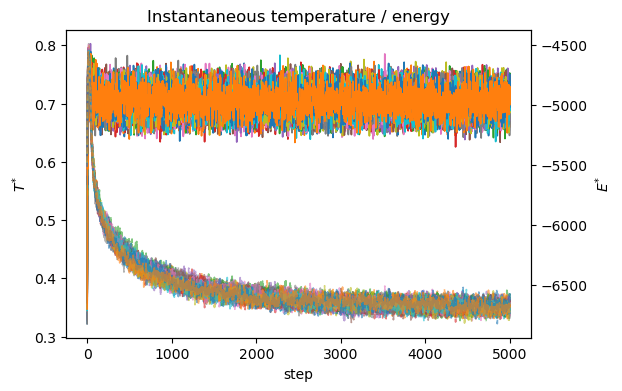

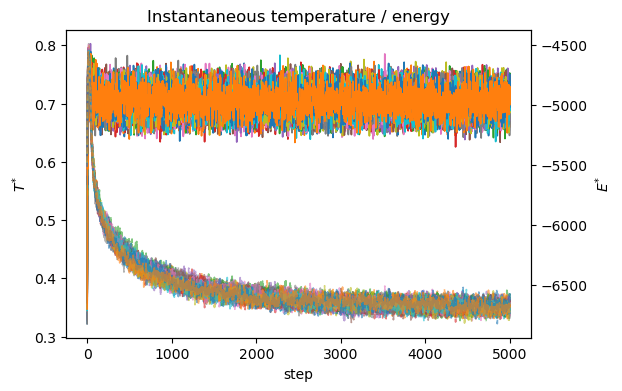

In [4]:
steps, eql_time, skip, bins = 2_000, 3_000, 50, 500
rmin, rmax = 0.5, 5.0

charge_dict = dict(A=-1, B=1, C=-2, D=2)
type_idx = dict( 
    A=A_idx, B=B_idx, C=C_idx, D=D_idx
)

pairs = list(itertools.combinations_with_replacement("ABCD", 2))  # 10 pairs
P = len(pairs)

temperature = torch.empty((steps + eql_time, B), device=device)
total_energy = torch.empty((steps + eql_time, B), device=device)
rdfs        = torch.empty((P, steps // skip, B, bins), device=device)

box_freud = freud.box.Box.from_box(b.edges.detach().cpu().numpy())

plt.ion()                            

plot_skip  = 100                    
show_reps  = range(0, B, 1)          

fig, ax = plt.subplots(figsize=(6, 4))

ax_e = ax.twinx()             

lines_T, lines_E = [], []   
for j in show_reps:
    (lnT,) = ax.plot([], [], lw=1.2, label=f"rep {j}")       # temperature
    (lnE,) = ax_e.plot([], [], lw=1.2, ls="--", alpha=0.6)   # energy (dashed)
    lines_T.append(lnT); lines_E.append(lnE)
ax.set_xlabel("step")
ax.set_ylabel(r"$T^{*}$")
ax_e.set_ylabel(r"$E^{*}$")
ax.set_title("Instantaneous temperature / energy")

fig.canvas.draw()                    

def _refresh_plot(step):
    x = np.arange(step + 1)

    for lnT, lnE, j in zip(lines_T, lines_E, show_reps):
        lnT.set_data(x, temperature[:step + 1, j].cpu())
        lnE.set_data(x, total_energy[:step + 1, j].cpu()) 

    for a in (ax, ax_e):
        a.relim(); a.autoscale_view()

    clear_output(wait=True)   # nuke old image
    display(fig)              # show the updated one

# EQUILIBRATION
with torch.no_grad():
    for i in trange(eql_time, desc="Equilibrating"):
        temperature[i] = S.temperature()
        total_energy[i] = S.total_energy()
        integrator.step(S)
        S.pos = S.pos - (S.mass.unsqueeze(-1) * S.pos).sum(dim=1, keepdim=True) / S.mass.sum(dim=1, keepdim=True).unsqueeze(-1)

        if i % plot_skip == 0:
            _refresh_plot(i)

        S.reset_cache()

# PRODUCTION
with torch.no_grad():
    for i in trange(steps, desc="Production"):
        step_glob = i + eql_time
        temperature[step_glob] = S.temperature()
        total_energy[step_glob] = S.total_energy()
        
        if step_glob % plot_skip == 0:
            _refresh_plot(step_glob)
            
        if i % skip == 0:
            tslot = i // skip  # time slot in rdfs

            for j in range(B):                          # each walker
                # grab positions per type once per walker to avoid repeats
                pos_j = {t: (S.pos[j, idx] - b.Lx).detach().cpu()
                           for t, idx in type_idx.items()}

                for pidx, (t1, t2) in enumerate(pairs):
                    rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
                    rdf.compute(system=(box_freud, pos_j[t1]),
                                query_points=pos_j[t2], reset=False)
                    rdfs[pidx, tslot, j] = torch.tensor(rdf.rdf)

        integrator.step(S)
        S.reset_cache()
        # shift all atoms back to the center 
        S.pos = S.pos - (S.mass.unsqueeze(-1) * S.pos).sum(dim=1, keepdim=True) / S.mass.sum(dim=1, keepdim=True).unsqueeze(-1)

plt.ioff()                           
_refresh_plot(steps + eql_time - 1)  
plt.show()

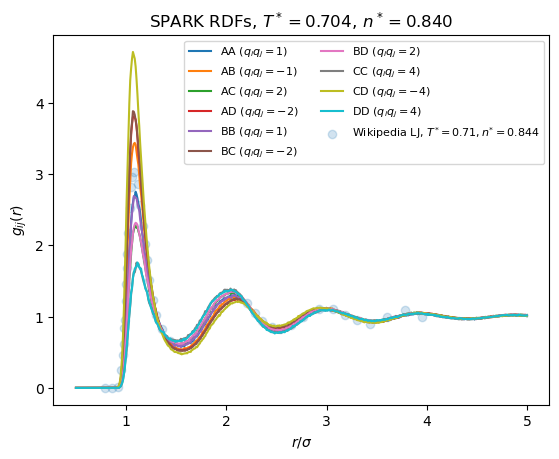

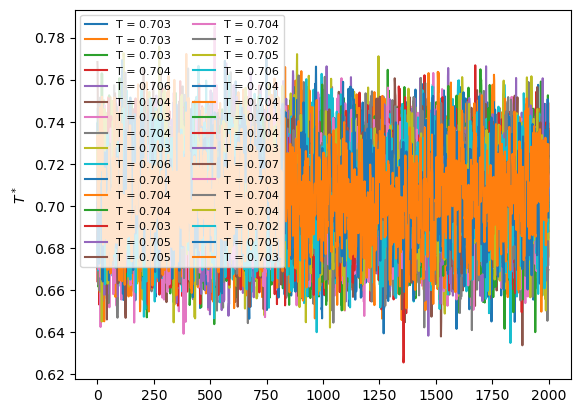

In [7]:
wikirdf = np.loadtxt("../LennardJonesFluid/wikipedia_rdf.csv", delimiter=",")

plt.title(
    fr"SPARK RDFs, $T^*={temperature.mean():.3f},\,n^*={len(pos[0])/b.volume:.3f}$"
)

for pidx, (t1, t2) in enumerate(pairs):
    qq = charge_dict[t1] * charge_dict[t2]
    g_r = rdfs[pidx].mean(dim=(0, 1)).cpu()         # avg over time & replicas
    plt.plot(rdf.bin_centers, g_r, label=f"{t1}{t2} ($q_iq_j={qq}$)")

plt.scatter(*wikirdf.T, alpha=0.2,
            label=r"Wikipedia LJ, $T^{*}=0.71,n^{*}=0.844$")
plt.legend(fontsize=8, ncols=2)
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"$g_{ij}(r)$")
plt.show()

for j in range(0, B, 1):
    plt.plot(temperature[eql_time:, j].cpu(), label=f"T = {temperature[eql_time:, j].mean():.3f}")
plt.legend(ncol=2, fontsize=8)
plt.ylabel(r"$T^*$")
plt.show()

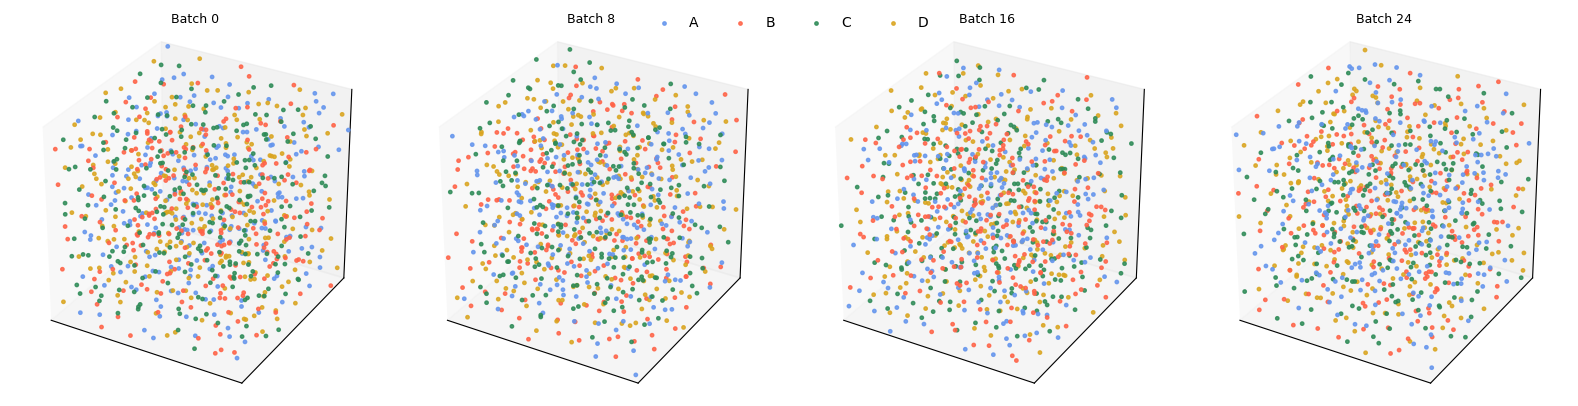

In [8]:
type_colors = dict(A="cornflowerblue",
                   B="tomato",
                   C="seagreen",
                   D="goldenrod")
type_idx = dict(A=A_idx, B=B_idx, C=C_idx, D=D_idx)

sel_batches = list(range(0, B, 8))
n_plots     = len(sel_batches)
n_cols      = min(4, n_plots)                 
n_rows      = math.ceil(n_plots / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for k, batch in enumerate(sel_batches):
    ax = fig.add_subplot(n_rows, n_cols, k + 1, projection="3d")

    # minimum‑image once per batch
    pos_mi = b.minimum_image(S.pos)[batch]

    for t, idx in type_idx.items():
        pts = pos_mi[idx].detach().cpu()
        ax.scatter(pts[:, 0],
                   pts[:, 1],
                   pts[:, 2],
                   s=6, alpha=0.85,
                   color=type_colors[t],
                   label=t if k == 0 else None)

    ax.set_title(f"Batch {batch}", fontsize=9, pad=2)
    ax.set_box_aspect((b.Lx.detach().cpu(), b.Ly.detach().cpu(), b.Lz.detach().cpu()))      # equal scale
    ax.set_xlim(-b.Lx.detach().cpu() / 2, b.Lx.detach().cpu() / 2)        
    ax.set_ylim(-b.Ly.detach().cpu() / 2, b.Ly.detach().cpu() / 2)
    ax.set_zlim(-b.Lz.detach().cpu() / 2, b.Lz.detach().cpu() / 2)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# one legend for all subplots
fig.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.02), frameon=False)

plt.tight_layout()
plt.show()
